In [5]:
from IPython.display import display, display_html, Math, Latex

import pandas as pd
import numpy as np
import numpy_financial as npf
import yfinance as yf
import matplotlib.pyplot as plt
import warnings
import networkx as nx

from itertools import combinations
from datetime import datetime
from threading import Thread

warnings.simplefilter(action='ignore', category=FutureWarning)

## Group Assignment
### Team Number: 01
### Team Member Names: Rehan, Rui, Anton
### Team Strategy Chosen: RISKY

### Global Variables

In [6]:
# Total Investment Size
investment = 500000

# File Name
file = 'Tickers_Example.csv'

# Start date and end date for our portfolio
start_date = '2022-01-01'
end_date = '2022-11-01'


### Extracting/filtering tickers based on assignment specifications and adding them to a list using multithreading for time efficiency

In [7]:
# Initializing a dataframe for 'raw' data extracted from the .csv file
tickers_raw = pd.read_csv(file, header=None)[0].tolist()

# Empty data structures to store ticker data in
tickers = []
tickers_hist = {}

# Function which consumes a ticker and determines the validation based on prerequisites
def validate_ticker(ticker):

    # Extracting ticker info from yFinance
    ticker_info = yf.Ticker(ticker).info

    # Trying every stock and excepting those that throw an error
    try:
        # If the stock is valid, we check for each prerequisite:
        # Checking for USD currency and ensuring it's on the US market
        if ticker_info['currency'] == 'USD' and ticker_info['market'] == 'us_market':
            ticker_hist = yf.Ticker(ticker).history(start=start_date, end=end_date, interval='1d').dropna()

            # Checking monthly volume
            ticker_monthly_trading_days = ticker_hist['Volume'].groupby(pd.Grouper(freq='MS')).count()
            ticker_monthly_volume = ticker_hist['Volume'].groupby(pd.Grouper(freq='MS')).sum()

            # Checking if the month has at least 20 trading days
            for month in ticker_monthly_trading_days.index:
                if ticker_monthly_trading_days.loc[month] < 20:
                    ticker_monthly_volume.drop(month, inplace=True)

            # Checking if the average monthly volume is greater than or equal to 200,000 USD
            if ticker_monthly_volume.mean() >= 200000:
                tickers.append(ticker)
                tickers_hist[ticker] = ticker_hist
            else:
                print(f'{ticker} Ticker does not meet average monthly volume requirements')
        else:
            print(f'{ticker} Ticker does not reference stock denominated in USD')
    except:
        print(f'Error: {ticker} Ticker does not reference a valid stock')

# Empty data structure for threading
threads = []

# Checking validity of each ticker in list of tickers given from threading
for ticker in tickers_raw:
    thread = Thread(target=validate_ticker, args=[ticker])
    thread.start()
    threads.append(thread)

# Using threading
for thread in threads:
    thread.join()

Error: TWX Ticker does not reference a valid stock
Error: PCLN Ticker does not reference a valid stock
Error: CELG Ticker does not reference a valid stock
Error: AGN Ticker does not reference a valid stock
Error: RTN Ticker does not reference a valid stock
RY.TO Ticker does not reference stock denominated in USD
TD.TO Ticker does not reference stock denominated in USD


### List of Valid Tickers

In [8]:
print(tickers)

['BAC', 'BLK', 'C', 'AIG', 'CSCO', 'PG', 'COF', 'UNP', 'KO', 'GOOG', 'USB', 'NEE', 'JPM', 'KMI', 'UPS', 'ACN', 'UNH', 'PM', 'ABT', 'MS', 'LLY', 'MON', 'AAPL', 'PEP', 'MSFT', 'AMZN', 'BIIB', 'AXP', 'TGT', 'T', 'COST', 'MO', 'SPG', 'TXN', 'CMCSA', 'SO', 'LMT', 'SLB', 'SBUX', 'CL', 'PYPL', 'ABBV', 'MRK', 'CAT', 'OXY', 'QCOM', 'CVS', 'BMY', 'COP', 'GM', 'BA', 'PFE', 'BK', 'ORCL', 'NKE']


---

## Strategy and Data Analytics

The strategy our team has chosen is to go risky, meaning we must optimize a portfolio so that it is driven away as much as possible, from the initial starting value of $500,000. Since we are pursuing a risky strategy, there are a few factors to an optimal portfolio.

Since we want the most risk and most reward, we want to minimize any diversification involved. Essentially, out of the minimum and maximum requirements for stock diversification, we want to pick the least amount of stocks, which is a minimum of 12 and keep diversification at an all time low. Furthermore, our stocks can net heavy volume, however, volume is useless if the market direction for these assets is all over the place. Therefore, we need all of our stocks to move in the same direction. 

Overall, we will move forward with the minimum amount of stocks involved, 12, and keep track of various factors like each stocks' weightings, risk to reward ratio, positive risk, negative risk, betas and options markets.

### Measuring Beta

Beta calculates the volatility of a stock given the covariance of the stock relative to the broader stock market and the variance of the stock. We can use this to our advantage and find the higher volatility stocks so that we can create a riskier portfolio. The formula for Beta is as follows:

$$
\beta_i = \frac {\mathrm{Cov} (r_i,r_m)}{\mathrm{Var} (r_m)}
$$


Where $ \beta_i $ is the market beta of a stock, $ {\mathrm{Cov} (r_i,r_m)} $ is the covariance between the stock and the market index (in our case, the S&P 500), $ {\mathrm{Var} (r_m)} $ is the variance of the market index. Since a volatile stock can net us a gain or a loss, we want the highest magnitude. Thus, we will be using Beta as a measure to quantify the portfolios we will be creating later so that we can rank them and subsequently, choose the greatest magnitude.

In [9]:
min_stocks = 12
max_stocks = 25

# Using the S&P 500 as our market index (the ticker is "^GSPC")
market_index = yf.Ticker('^GSPC').history(start=start_date, end=end_date, interval='1d').dropna()['Close']
market_return = market_index.pct_change()
market_variance = market_return.var()

# Dictionary to store the beta of every ticker
beta_dict = {}

# Calculating beta
for ticker in tickers:
    stock_return = tickers_hist[ticker]['Close'].pct_change()
    covariance = pd.DataFrame({ticker: stock_return, 'S&P 500': market_return}).cov().loc[ticker, 'S&P 500']
    beta_dict[ticker] = covariance / market_variance

# Storing all betas in a dataframe
beta_df = pd.DataFrame(beta_dict.items(), columns=['Ticker', 'Beta'])
beta_df.sort_values(by=['Beta'], ascending=False, ignore_index=True, inplace=True)

# Initializing a dictionary to store each portfolios' average betas for comparison purposes later
final_betas = {}

---

### Optimal Weighting for Stocks

Since we want the highest volatility possible, we want to invest the majority of our funds into the most volatile stock before investing into the others. Given the requirements of a stock only being a maximum of 25% of the entire portfolio or a minimum of 100/2n where n is the number of stocks we have chosen (in our case, 12), we have calculated an optimal weighting below to create the most volatility.

In [10]:
min_weighting = 100 / (min_stocks * 2)
max_weighting = 25
total_weighting = 0 
min_stocks

# This list will have the weightings of our 12 prospective stocks
list_of_weighting = []

# This program puts the majority of the weighting at the beginning of the list (so that the more volatile stocks can take them up first)
while (min_stocks != 0):
    temp_weighting = min_weighting * (min_stocks - 1)
    remaining_weight = 100 - (temp_weighting + total_weighting)
    
    if (remaining_weight > max_weighting):
        list_of_weighting.append(max_weighting/100)
        total_weighting += max_weighting
    elif (remaining_weight > min_weighting):
        list_of_weighting.append(remaining_weight/100)
        total_weighting += remaining_weight
    else:
        list_of_weighting.append(min_weighting/100)
        total_weighting += min_weighting
    min_stocks -= 1

Here is the list of weightings:

In [11]:
print (list_of_weighting)

[0.25, 0.25, 0.125, 0.04166666666666667, 0.04166666666666667, 0.04166666666666667, 0.04166666666666667, 0.04166666666666667, 0.04166666666666667, 0.04166666666666667, 0.04166666666666667, 0.04166666666666667]


---

#### Below is the function that calculates the number of shares we will invest in each stock ####

In [12]:
# This function calculates the number of stocks to invest in given a list of 12 stocks
def num_stocks (tickers_list):
    
    # Calculating the $ amount to invest into each stock 
    investment_list = []
    for i in range(len(list_of_weighting)):
        investment_list.append((list_of_weighting[i] * investment))
        
    # Getting the number of stocks invested in each ticker
    stocks_in_each = []
    price_of_each = []
    for i in range(len(tickers_list)):
        stocks_in_each.append (investment_list[i] / tickers_hist.get(tickers_list[i])['Close'][0])
        price_of_each.append(tickers_hist.get(tickers_list[i])['Close'][0])

    frame = {"Ticker": tickers_list,
             "Price": price_of_each,
             "Shares": stocks_in_each,
             "Value": investment_list,
             "Weight": list_of_weighting}
    
    stocks_dataframe = pd.DataFrame(frame)

    return (stocks_dataframe)

portfolio_candidates = {} #This variable stores each strategy's portfolios to export into a .csv file later on

---

#### Below is the function that will generate our portfolios ####
We will also be defining a function that can generate our portfolio over a period of time so that we can visually see how each portfolio performs relative to each other.

In [13]:
# generate_portfolio consumes a ticker and tracks the ticker's performance over a time period
def generate_portfolio(ticker, num_stocks):
    
    # Finding the number of trading days for the stock
    ticker_hist = yf.Ticker(ticker).history(start=start_date, end=end_date, interval='1d').dropna() 
    days_trading = len(ticker_hist.index)
        
    
    # Calculating how the stock performs over this time period
    values = []
    for i in range(days_trading):
        value = tickers_hist.get(ticker)['Close'][i] * num_stocks
        values.append(value)
         
    return values
    
# generate_combined_portfolio consumes a dataframe (index, "Ticker", "Stock", "Investment") 
# and generates the portfolio over the time period
def generate_combined_portfolio(dataframe):
    final_df = pd.DataFrame()
    values_list = []
    ticker_list = []

    # Loop over the dataframe's index to append the ticker and the shares of each ticker
    for i in range(len(dataframe.index)):
        ticker = dataframe['Ticker'][i]
        ticker_list.append(ticker)
        values_list.append(generate_portfolio(ticker, dataframe['Shares'][i]))

    # Loop over the dataframe's index to append the individual tickers' portfolios to each other
    for i in range(len(dataframe.index)):
        frame = {ticker_list[i]: values_list[i]}
        final_df[ticker_list[i]] = pd.DataFrame(frame)

    final_df = final_df.set_index(tickers_hist.get(dataframe['Ticker'][0]).index)

    # Total value of the portfolio on one column
    final_df['Total Value'] = final_df.sum(axis=1)
    
    return final_df

Now that we have finished setting up our quantifiers and portfolio generators, we can move on to the strategies we will be implementing to yield a portfolio with the highest volatility.

---

### Correlation ###
Since we want the stocks to move in the same general direction, we will need to compare their movements relative to the market index. Thus, we will be using the __Correlation Coefficient__ to determine which stocks are the most correlated to S&P500. Since a stock could be directly correlated or inversely correlated (though very unlikely), we will be accounting for an upper bound of and a lower bound (so we will have a list of 12 stocks that are the most correlated and 12 stocks that are the most inversely correlated). Afterwards, we can obtain the mean beta of each list and yield the highest magnitude as a contender for our final portfolio.

The formula for correlation is given by: 
\begin{align*}
COR(X,Y)=\frac{COV(X,Y)}{\sigma_X \times \sigma_Y}
\end{align*}
Where, for our purposes, $ COR(X,Y) $ is the correlation between a stock and the market index, $ {\sigma_X } $ is the deviation of the stock and $ { \sigma_Y } $ is the deviation of the market index.


In [14]:

# Setting up correlation dictionary for all tickers
corr_dict = {}

# Calculating correlation
for ticker in tickers:
    stock_return = tickers_hist[ticker]['Close'].pct_change()
    corr = pd.DataFrame({ticker: stock_return, 'S&P 500': market_return}).corr().loc[ticker, 'S&P 500']
    corr_dict[ticker] = corr

# Creating correlation dataframe for all tickers
corr_df = pd.DataFrame(corr_dict.items(), columns=['Ticker', 'Correlation'])
corr_df.sort_values(by=['Correlation'], ascending=False, ignore_index=True, inplace=True)


Below are the tickers with the highest correlation:

In [15]:
corr_df.head(12)

,Ticker,Correlation
0,ACN,0.892554
1,AAPL,0.882333
2,MSFT,0.866140
3,BLK,0.861315
4,GOOG,0.829202
5,TXN,0.804366
6,NKE,0.780587
7,MS,0.776555
8,AMZN,0.774818
9,QCOM,0.766427


Below are the tickers with the lowest correlation:

In [16]:
corr_df.tail(12)

,Ticker,Correlation
43,BIIB,0.432732
44,T,0.421944
45,BMY,0.386757
46,MRK,0.377811
47,PM,0.375340
48,COP,0.371408
49,ABBV,0.347691
50,MO,0.328813
51,SLB,0.311781
52,OXY,0.300052


In [17]:
# Top 12 tickers with the highest correlation to the S&P 500
corr_high_mean = corr_df.head(12)['Correlation'].mean()
# Lowest 12 tickers with the lowest correlation to the S&P 500
corr_low_mean = corr_df.tail(12)['Correlation'].mean()

# Getting the list with a higher correlation on average
if (corr_high_mean > corr_low_mean):
    corr_tickers = list(corr_df.head(12)['Ticker'])
else:
    corr_tickers = list(corr_df.tail(12)['Ticker'])

Here is the list of tickers we will be using for the correlation portfolio:

In [18]:
print(corr_tickers)

['ACN', 'AAPL', 'MSFT', 'BLK', 'GOOG', 'TXN', 'NKE', 'MS', 'AMZN', 'QCOM', 'AXP', 'GM']


In [19]:
# Getting the beta of each stock from our correlation tickers and sorting them from highest to lowest
corr_df = pd.DataFrame(corr_tickers, columns = ['Ticker'])
corr_df['Beta'] = corr_df['Ticker'].replace(beta_dict)

corr_df.sort_values(by = ['Beta'], ascending=False, ignore_index = True, inplace = True)
corr_tickers = list(corr_df['Ticker']) # reorganizing the list so that the highest betas come first
corr_beta = corr_df['Beta'].mean()
final_betas['Correlation'] = corr_beta

Here is the tickers' and their respective betas:

In [20]:
display(corr_df)

,Ticker,Beta
0,AMZN,1.604552
1,QCOM,1.454487
2,GM,1.393548
3,GOOG,1.310727
4,NKE,1.300717
5,BLK,1.269739
6,AAPL,1.265965
7,MSFT,1.247844
8,ACN,1.164351
9,AXP,1.141406


The corresponding weighting and investment amount into each stock is:

In [21]:
# Displaying the tickers with the highest correlation, and their respective investment weights
corr_df = num_stocks(corr_tickers)
portfolio_candidates["Correlation"] = corr_df
display(corr_df)

,Ticker,Price,Shares,Value,Weight
0,AMZN,170.404495,733.548724,125000.000000,0.250000
1,QCOM,186.210007,671.285084,125000.000000,0.250000
2,GM,61.169998,1021.742715,62500.000000,0.125000
3,GOOG,145.074493,143.604385,20833.333333,0.041667
4,NKE,164.669998,126.515659,20833.333333,0.041667
5,BLK,911.729980,22.850333,20833.333333,0.041667
6,AAPL,182.009995,114.462579,20833.333333,0.041667
7,MSFT,334.750000,62.235499,20833.333333,0.041667
8,ACN,406.156982,51.293796,20833.333333,0.041667
9,AXP,167.788895,124.163958,20833.333333,0.041667


The resulting portfolio is:

In [22]:
corr_portfolio = generate_combined_portfolio(corr_df)
display(corr_portfolio)

,AMZN,QCOM,GM,GOOG,NKE,BLK,AAPL,MSFT,ACN,AXP,TXN,MS,Total Value
Date,,,,,,,,,,,,,
2022-01-03,125000.000000,125000.000000,62500.000000,20833.333333,20833.333333,20833.333333,20833.333333,20833.333333,20833.333333,20833.333333,20833.333333,20833.333333,500000.000000
2022-01-04,122885.551624,125684.703411,67169.363895,20738.843156,21050.940421,20958.781436,20568.925056,20476.102176,20684.454844,21502.139343,20855.193790,21679.641547,504254.640699
2022-01-05,120563.863646,125194.668167,64104.139648,19767.646633,20527.165670,20377.241586,20021.794069,19690.067518,20320.187182,21273.009323,20420.164540,21143.160120,493403.108103
2022-01-06,119754.761731,124825.459323,64236.963395,19752.925957,20374.080873,20462.244154,19687.563549,19534.478770,19338.916267,21467.947647,20413.604902,21504.972692,491353.919261
2022-01-07,119241.279863,121106.544464,63623.919325,19674.447090,19859.163145,20388.666753,19707.021977,19544.436678,18967.998945,21651.711670,19613.500863,21635.973934,485014.664708
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-10-25,88465.974962,79997.042232,37814.696164,15068.408110,11604.016397,14531.440596,17437.228831,15599.950440,14393.551298,18254.585692,17724.728759,16857.770583,347749.394063
2022-10-26,84842.248073,79285.481682,38683.179810,13616.567695,11688.781656,14573.941880,17094.986838,14396.316114,14355.594390,18237.202814,17255.813884,16941.525815,340971.640651
2022-10-27,81394.565713,76996.397087,38989.701845,13297.765786,11454.727880,14829.408432,16574.181755,14111.899427,14302.761843,18248.377116,17134.486434,16895.460357,334229.733676


Thus our correlation portfolio has been created and we will be moving on to the other portfolio types

---

## Options Market

Essentially, put options can be described as contracts which allow the buyer of the option contract to sell a specific stock at a pre-specified price. Therefore, an increase of buyers of put options can indicate that investors are speculating that the stock price will fall. Contrarily, call options can be described as contracts which allow the buyer of the option contract to buy a specific stock at a pre-specified price. Hence, an increase of buyers of call options can indicate that investors are speculating that the stock price will increase.

### Put-to-Call and Call-to-Put Ratio ###

By analyzing the sums of the puts and the calls, we can calculate the put-to-call ratio and call-to-put ratios to estimate upcoming investor sentiment in the short term. If the put-to-call ratio is greater than 1, then the ratio indicates more put options are being bought than call options, and thus market sentiment is leading more towards the idea of the stock price decreasing. Otherwise, if the call-to-put ratio is greater than 1, then the ratio indicates more call options are being bought than put options, and thus market sentiment is leading more towards the idea of the stock price increasing.

### Checking if the options market is large enough for the chosen stocks:

In [23]:
# Global variables to check for availability of options, put-to-call ratios and call-to-put ratios
options_large_enough = False
pcr_large_enough = False
cpr_large_enough = False

In [24]:
# Creating a 2D 
options_evaluation_raw = {}
options_evaluation_raw['puts_sum'] = {}
options_evaluation_raw['calls_sum'] = {}
options_evaluation_raw['pcr'] = {}
options_evaluation_raw['cpr'] = {}

def extract_options_market(ticker):

    try:
        # Extracting options data from Yahoo Finance
        asset = yf.Ticker(ticker)
        options = asset.option_chain(asset.options[0])

        # Extracting puts volume from options data
        puts = pd.DataFrame().append(options.puts)
        puts_sum = puts['volume'].sum()
        options_evaluation_raw["puts_sum"][ticker] = puts_sum

        # Extracting calls volume from options data
        calls = pd.DataFrame().append(options.calls)
        calls_sum = calls['volume'].sum()
        options_evaluation_raw["calls_sum"][ticker] = calls_sum

        # Calculating put-to-call ratio
        puts_to_calls =  puts_sum / calls_sum
        options_evaluation_raw["pcr"][ticker] = puts_to_calls

        # Calculating call-to-put ratio
        calls_to_puts =  calls_sum / puts_sum
        options_evaluation_raw["cpr"][ticker] = calls_to_puts
    
    except IndexError as error:
        print(f'Dropped {ticker}, no options data available')
    
# Checking options market of each ticker in list of tickers given from threading
for ticker in tickers:
    thread = Thread(target=extract_options_market, args=[ticker])
    thread.start()
    threads.append(thread)

for thread in threads:
    thread.join()        


Dropped MON, no options data available


In [25]:
# Checking if there is sufficient options data for the minimum number of stocks
if len(options_evaluation_raw.keys()) <= min_stocks:
    options_large_enough = True
    options_evaluation = pd.DataFrame(options_evaluation_raw)
    print("The options market was large enough for at least 12 stocks. Here is the summary:")
    display(options_evaluation.head())
else:
    print("There was insufficient options data for the tickers provided.")

There was insufficient options data for the tickers provided.


Let's filter for any stocks with a put-to-call ratio which is below one, and filter for any stocks with a call-to-put ratio which is below one separately. We want our portfolio to move large in one direction, so we must account for stocks which may offset any gains and losses from other stocks. Thus, we will create a portfolio strictly consisting of heavy put-to-call ratio stocks and another portfolio strictly consisting of heavy call-to-put ratio stocks for further comparison. If only one portfolio can be formed, then the comparison step will be skipped.

In [26]:
if options_large_enough:
    # Filtering for stocks with a puts-to-calls ratio greater than 1 and sorting
    pcr_filter = pd.DataFrame()
    pcr_filter = options_evaluation[options_evaluation["pcr"] > 1].dropna()
    pcr_filter = pcr_filter.sort_values(by=['pcr'], ascending=False)
    print("Displaying the puts-to-calls ratios for the stocks:")
    display(pcr_filter.head())
else:
    print("The options market had insufficient data, skipping...")

The options market had insufficient data, skipping...


Forming the portfolio for the heavy put-to-call ratio stocks,

In [27]:
# Checking if there are enough heavy puts-to-calls ratio stocks
if options_large_enough and len(pcr_filter) >= 12:
    print("There are at least 12 stocks with a heavy puts-to-calls ratio.")
    pcr_large_enough = True
    pcr_heavy_tickers = []
    pcr_heavy_tickers = list(pcr_filter.index.values)
    # Removing everything after the first 12 tickers
    pcr_heavy_tickers = pcr_heavy_tickers[0:12]
    print(pcr_heavy_tickers)
else: 
    print("There are not enough stocks with a puts-to-calls ratio greater than 1.")


There are not enough stocks with a puts-to-calls ratio greater than 1.


In [28]:
if options_large_enough:
    # Filtering for stocks with a calls-to-puts ratio greater than 1
    cpr_filter = pd.DataFrame()
    cpr_filter = options_evaluation[options_evaluation["cpr"] > 1].dropna()
    cpr_filter = cpr_filter.sort_values(by=['cpr'], ascending=False)
    print("Displaying the calls-to-puts ratios for the stocks:")
    display(cpr_filter.head())
else:
    print("The options market had insufficient data, skipping...")

The options market had insufficient data, skipping...


In [29]:
# Checking if there are enough heavy calls-to-puts ratio stocks
if options_large_enough and len(cpr_filter) >= 12:
    print("There are at least 12 stocks with a heavy calls-to-puts ratio.")
    cpr_large_enough = True
    cpr_heavy_tickers = []
    cpr_heavy_tickers = list(cpr_filter.index.values)
    # Removing everything after the first 12 tickers
    cpr_heavy_tickers = cpr_heavy_tickers[0:12]
    print(cpr_heavy_tickers)
else: 
    print("There are not enough stocks with a calls-to-puts ratio greater than 1.")


There are not enough stocks with a calls-to-puts ratio greater than 1.


### Calculating betas for the portfolios with heavy calls-to-puts ratios and heavy puts-to-calls ratios

In [30]:
if cpr_large_enough:
    # Getting the call-to-put ratio portfolios' betas
    cpr_df = pd.DataFrame(cpr_heavy_tickers, columns = ['Ticker'])
    cpr_df['Beta'] = cpr_df['Ticker'].replace(beta_dict)

    cpr_df.sort_values(by = ['Beta'], ascending=False, ignore_index = True, inplace = True)
    display(cpr_df)
else:
    print("The call-to-put ratio was not available for enough stocks.")

The call-to-put ratio was not available for enough stocks.


In [31]:
if pcr_large_enough:
    # Getting the put-to-call ratio portfolios' betas
    pcr_df = pd.DataFrame(pcr_heavy_tickers, columns = ['Ticker'])
    pcr_df['Beta'] = pcr_df['Ticker'].replace(beta_dict)

    pcr_df.sort_values(by = ['Beta'], ascending=False, ignore_index = True, inplace = True)

    display(pcr_df)
else:
    print("The put-to-call ratio was not available for enough stocks.")

The put-to-call ratio was not available for enough stocks.


In [32]:
if (cpr_large_enough and pcr_large_enough):
    # Generating portfolios for PCR and CPR stocks
    pcr_list = pcr_df['Ticker'].tolist()
    pcr_candidate = num_stocks(pcr_list)
    pcr_portfolio = generate_combined_portfolio(pcr_candidate)
    cpr_list = cpr_df['Ticker'].tolist()
    cpr_portfolio = generate_combined_portfolio(num_stocks(cpr_list))

    # Graphing the portfolios
    plt.figure(figsize=(20, 5))
    plt.plot(pcr_portfolio.index, pcr_portfolio['Total Value'], label='PCR Portfolio')
    plt.plot(cpr_portfolio.index, cpr_portfolio['Total Value'], label='CPR Portfolio')

    plt.title('PCR vs CPR Portfolio')
    plt.xlabel('Dates')
    plt.ylabel('Value')

    plt.legend()
    plt.show()

elif(cpr_large_enough):
    # Generating protfolio for CPR stocks
    cpr_list = cpr_df['Ticker'].tolist()
    cpr_candidate = num_stocks(cpr_list)
    cpr_portfolio = generate_combined_portfolio(cpr_candidate)

    # Graphing the portfolio
    plt.figure(figsize=(20, 5))
    plt.plot(cpr_portfolio.index, cpr_portfolio['Total Value'], label='CPR Portfolio')

    plt.title('CPR Portfolio')
    plt.xlabel('Dates')
    plt.ylabel('Value')

    plt.legend()
    plt.show()

elif(pcr_large_enough):
    # Gererating portfolios for PCR stocks
    pcr_list = pcr_df['Ticker'].tolist()
    pcr_portfolio = generate_combined_portfolio(num_stocks(pcr_list))

    # Graphing the portfolios
    plt.figure(figsize=(20, 5))
    plt.plot(pcr_portfolio.index, pcr_portfolio['Total Value'], label='PCR Portfolio')

    plt.title('PCR Portfolio')
    plt.xlabel('Dates')
    plt.ylabel('Value')

    plt.legend()
    plt.show()
else:
    print ("None of the options markets were large enough.")


None of the options markets were large enough.


### Comparing puts-to-calls and calls-to-puts portfolios and their Betas ###
The above should graph the puts-to-calls and calls-to-puts portfolios. In the case that only one of them is available, it will only print the available one. If none are available, then we will skip this part of the data analytics.

#### Analysis ####
In the case that both the calls-to-puts and puts-to-calls portfolios are available (and graphed), then we can compare the magnitude of the difference between their starting point and ending point. The portfolio with the greater different in magnitude should also correspond to having a __higher__ beta value. 

In [33]:
# Determines which portfolio to take as our options portfolio to compare with our other strategies later on
use_cpr = False
use_pcr = False

# Getting the average of the top cpr tickers and the top pcr tickers
if (cpr_large_enough and pcr_large_enough):
    cpr_beta_mean = cpr_df['Beta'].mean()
    pcr_beta_mean = pcr_df['Beta'].mean()
elif (cpr_large_enough):
    cpr_beta_mean = cpr_df['Beta'].mean()
    print("The only options market available is the calls-to-puts ratio and the overall beta is: " + str(cpr_beta_mean))
elif (pcr_large_enough):
    pcr_beta_mean = pcr_df['Beta'].mean()
    print("The only options market available is the puts-to-calls ratio and the overall beta is: " + str(pcr_beta_mean))
else:
    print("None of the options markets were large enough, thus the options market will have no influence over our final portfolio")
    
# Comparing the magnitudes of the cpr and pcr tickers and choosing the larger one for our options portfolio
if (cpr_large_enough and pcr_large_enough):
    if (cpr_beta_mean > pcr_beta_mean):
        options_portfolio = cpr_portfolio
        use_cpr = True
        options_beta = cpr_beta_mean # Setting the options beta to be the beta of the higher magnitude options portfolio
        final_betas['Options'] = options_beta # Recording the beta of the options portfolio to compare with the others
        portfolio_candidates["Options"] = cpr_candidate # Dictionary from earlier to store portfolio candidates
        print("The greater beta comes from the calls-to-puts ratio and the overall beta of it is: " + str(cpr_beta_mean))
        print("Thus, our options portfolio will be based on the calls-to-puts ratio")
    elif (cpr_beta_mean < pcr_beta_mean):
        options_portfolio = pcr_portfolio
        use_pcr = True
        options_beta = pcr_beta_mean
        final_betas['Options'] = options_beta
        portfolio_candidates["Options"] = pcr_candidate
        print("The greater beta comes from the puts-to-calls ratio and the overall beta of it is: " + str(pcr_beta_mean))
        print("Thus, our options portfolio will be based on the puts-to-calls ratio")
        

None of the options markets were large enough, thus the options market will have no influence over our final portfolio


---

## K-MST Algorithm

---

### Comparing the different strategies ###

Now that we have all of our portfolios, we can graph and quantify them by their magnitudes of beta to determine which portfolio we will use as our final.

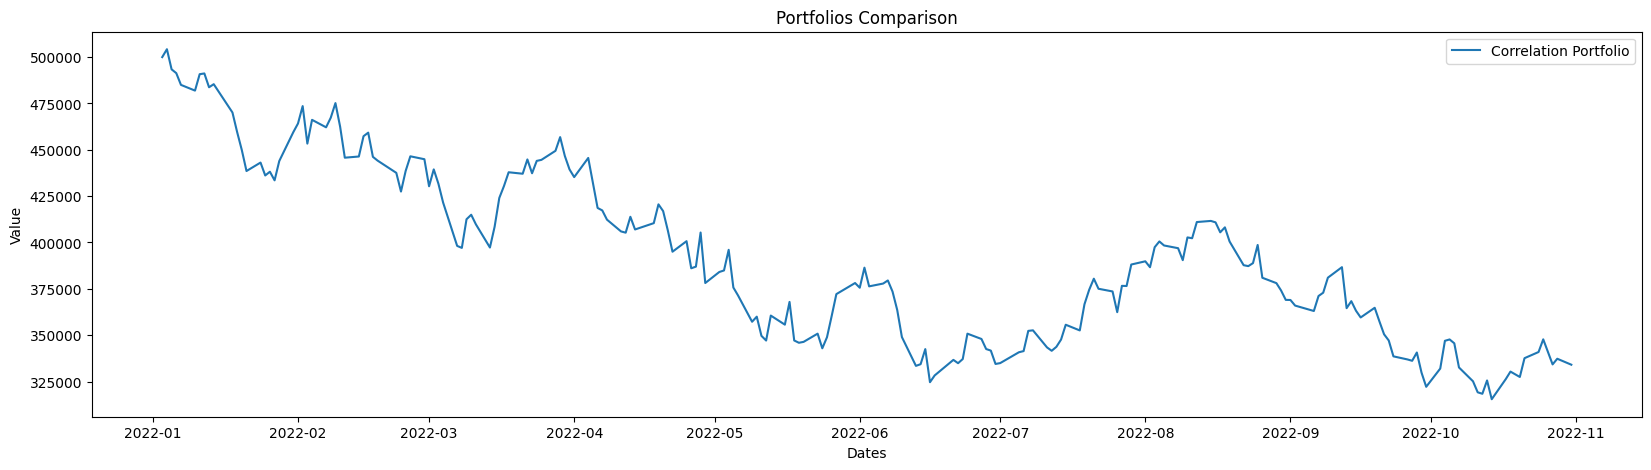

In [34]:
# Graphing the portfolios:
if (pcr_large_enough and cpr_large_enough):
    if (use_pcr):
        plt.figure(figsize=(20, 5))
        plt.plot(options_portfolio.index, options_portfolio['Total Value'], label='PCR Portfolio')
        plt.plot(corr_portfolio.index, corr_portfolio['Total Value'], label='Correlation Portfolio')
        #plot k-MST algorithm portfolio here

        plt.title('Portfolios Comparison')
        plt.xlabel('Dates')
        plt.ylabel('Value')

        plt.legend()
        plt.show()
    elif (use_cpr):
        plt.figure(figsize=(20, 5))
        plt.plot(options_portfolio.index, options_portfolio['Total Value'], label='CPR Portfolio')
        plt.plot(corr_portfolio.index, corr_portfolio['Total Value'], label='Correlation Portfolio')
        #plot k-MST algorithm portfolio here

        plt.title('Portfolios Comparison')
        plt.xlabel('Dates')
        plt.ylabel('Value')

        plt.legend()
        plt.show()
else:
    plt.figure(figsize=(20, 5))
    plt.plot(corr_portfolio.index, corr_portfolio['Total Value'], label='Correlation Portfolio')
    #plot k-MST algorithm portfolio here

    plt.title('Portfolios Comparison')
    plt.xlabel('Dates')
    plt.ylabel('Value')

    plt.legend()
    plt.show()


The above graph shows how each portfolio performs over a 1 year time period. The portfolio that ends the furthest away from the starting investment of 500 000 USD should also correspond to having a greater magnitude of beta.

In [35]:
if (use_cpr or use_pcr):
    print ("The options portfolio's average beta is: " + str(options_beta))
print ("The correlation portfolio's average beta is: " + str(corr_beta))
print ("The k-MST algorithm portfolio's average beta is: ") #add k-MST average beta here

The correlation portfolio's average beta is: 1.2718561700305029
The k-MST algorithm portfolio's average beta is: 


In [36]:
max_beta = max(final_betas, key=final_betas.get)
print("The max beta value we got is from the " + max_beta + " portfolio")

The max beta value we got is from the Correlation portfolio


#### Creating the "Portfolio_Final" as required by assignment specifications ####

In [37]:
Portfolio_Final = portfolio_candidates.get(max_beta)
display(Portfolio_Final)

,Ticker,Price,Shares,Value,Weight
0,AMZN,170.404495,733.548724,125000.000000,0.250000
1,QCOM,186.210007,671.285084,125000.000000,0.250000
2,GM,61.169998,1021.742715,62500.000000,0.125000
3,GOOG,145.074493,143.604385,20833.333333,0.041667
4,NKE,164.669998,126.515659,20833.333333,0.041667
5,BLK,911.729980,22.850333,20833.333333,0.041667
6,AAPL,182.009995,114.462579,20833.333333,0.041667
7,MSFT,334.750000,62.235499,20833.333333,0.041667
8,ACN,406.156982,51.293796,20833.333333,0.041667
9,AXP,167.788895,124.163958,20833.333333,0.041667


Confirming that the value adds up to 500 000 and that the weight adds up to 1 (which is 100%)

In [38]:
print ("The total value of the portfolio is: " + str(Portfolio_Final['Value'].sum()))
print ("The total weight of the portfolio is: " + str(Portfolio_Final['Weight'].sum()))

The total value of the portfolio is: 500000.0
The total weight of the portfolio is: 1.0


#### Creating "Stocks_Final" to export into a .csv file ####

In [39]:
Stocks_Final = pd.DataFrame()
Stocks_Final['Ticker'] = Portfolio_Final['Ticker']
Stocks_Final['Shares'] = Portfolio_Final['Shares']

In [40]:
Stocks_Final.to_csv('Stocks_Group_01.csv')

## Contribution Declaration

The following team members made a meaningful contribution to this assignment:

Rui, Rehan, Anton